# Python imports

In [1]:
import csv, time
import numpy as np
import multihash as mh
import hashlib as hl
import matplotlib.pyplot as plt
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring

# Plot design

In [96]:
plt.rc('font', size=28)

# Helper functions and classes

In [3]:
# turn a peer_id (e.g 12D3KooWEZXjE41uU4EL2gpkAQeDXYok6wghN7wwNVPF5bwkaNfS) to its
# sha256 hash representation (256 bits), used as kademlia identifier
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

# XOR two bitstring of equal size, the size doesn't need to be a multiple of 8
def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# returns the XOR distance (in bytes) between the two provided bytes arrays
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


## Nebula peer object

This object is used to keep track of the peer's routing table, and its various identifiers

In [4]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)


# Gathering data for plots

## Global variables used to collect data from the crawls before plotting it

In [19]:
routing_table_distribution_in_kbuckets_data = [[] for _ in range(257)]
routing_table_distribution_in_kbuckets_alive_data = [[] for _ in range(257)]

In [20]:
peerids_distribution_data = []
peerids_distribution_chunk88_data = [] # 1011000

In [21]:
closest20_cdf_data = []

In [22]:
missing_peers_per_bucket_data = []
missing_peers_per_non_full_bucket_data = []

In [23]:
closest_peers_data = [[] for _ in range(20)]

## Functions to compute the different measurements on each crawl

In [24]:
# aggregating the number of entries per bucket for all peers
def routing_table_distribution_in_kbuckets(peers):
    for pid in peers:
        p=peers[pid]
        for i in range(len(p.buckets)):
            routing_table_distribution_in_kbuckets_data[i].append(len(p.buckets[i]))

            count = 0
            for neighbor in p.buckets[i]:
                if neighbor.alive:
                    count += 1
            routing_table_distribution_in_kbuckets_alive_data[i].append(count)


In [26]:
# adds the number of known peers among the 20 closest to 'closest20_cdf_data'
def closest20_cdf(peers, all_peers, trie):
    neighbors20 = []
    for p in peers:
        # get the 20 global closest peers that exist
        peers20 = trie.n_closest(bytes_to_bitstring(peers[p].key), 21)[1:]
        # we should test the actual neighbors e.g peers[p].neighbors
        neighbors = [all_peers[p].neighbors[n].key for n in all_peers[p].neighbors]

        # check if these peers are in the node's routing table
        count = 0
        for p in peers20:
            if p.key in neighbors:
                count+=1
        neighbors20.append(count)

    closest20_cdf_data.append(neighbors20)

In [27]:
# computes how many peers should be in each bucket, but are actually missing
def missing_peer_in_buckets(peers, trie):
    non_full_buckets = [0] * 255
    missing_peers_in_bucket = [0] * len(non_full_buckets)

    for p in peers:
        # iterates on all peers
        for bid in range(len(non_full_buckets)):
            # iterates on all the buckets from this peers
            blen = len(peers[p].buckets[bid])
            # if bucket is full (20), go to next peer
            if blen < 20:
                non_full_buckets[bid] += 1

                # bucket number = CPL
                key = bytes_to_bitstring(peers[p].key)
                path = key[:bid]+str(1-int(key[bid+1]))

                # get the subtrie corresponding to this specific bucket
                subtrie = trie.find_trie(path)
                if subtrie is None:
                    # we want to find out if it is included in a path
                    # or if it is not present at all in the trie
                    subtrie = trie
                    while len(subtrie.key) < len(path):
                        subtrie = subtrie.branch[int(path[len(subtrie.key)])]
                        m = min(len(path),len(subtrie.key)+1)
                        if subtrie.key[:m] != path[:m]:
                            # subtrie doesn't exist
                            subtrie = None
                            break

                # the global subtrie corresponding to the bucket is larger
                # than the bucket, we compute the difference
                if subtrie is not None and subtrie.size > blen:
                    missing_peers_in_bucket[bid] += min(subtrie.size,20) - blen
                    
    missing_peers_per_bucket_data.append([missing_peers_in_bucket[i]/len(peers) for i in range(len(non_full_buckets))])
    missing_peers_per_non_full_bucket_data.append([missing_peers_in_bucket[i]/non_full_buckets[i] if non_full_buckets[i] > 0 else 0 for i in range(len(non_full_buckets))])
                


In [28]:
# compute to which buckets the 20 closest peers individually belong
def closest20_bucket_distribution(peers, all_peers, trie):
    for p in peers:
        # get 20 closest neighbors from the trie
        closest20 = trie.n_closest(bytes_to_bitstring(all_peers[p].key), 21)[1:]

        for i in range(len(closest20)):
            # for each peer, compute the bucket id
            d=xor_distance(peers[p].key, closest20[i].key)
            bucket=bucket_number_for_distance(d)

            closest_peers_data[i].append(bucket)


# Loading data exctracted from the Nebula Crawler DB

- `nebula_peerids` is a mapping from the Nebula ID to the peer ID for all hosts observed by Nebula over the time period `2022-02-16 10:30:01.706317+01` to `2022-05-03T13:01:17.238Z`

- `all_crawls` is a list of `[crawl_id, nebula_id, peer_id, neighbor0, neighbor1, ... neighborN]` for all diable peers for the selected crawls.


In [29]:
with open("data/all-peerids.csv", 'r') as file:
    nebula_peerids = {line[0]:line[1] for line in csv.reader(file)}

Available data files are:
- `data/nebula-peers-2crawls.csv` in [data/](https://github.com/protocol/network-measurements/tree/master/implementations/rfm19-dht-routing-table-health/data) folder.
- `data/nebula-peers-5crawls.csv` on [web3.storage](ipfs://bafybeiaqr6csdcnxrkpx23oithpjtuhpzudq43pkciavygsfr3i5qz6dcy), CID: `bafybeiaqr6csdcnxrkpx23oithpjtuhpzudq43pkciavygsfr3i5qz6dcy`
- `data/nebula-peers-1week.csv` on [web3.storage](ipfs://bafybeif6u5pukl3szezll4myp77eebeyq6ywp7hveahyllutsj7hepxltq), CID: `bafybeif6u5pukl3szezll4myp77eebeyq6ywp7hveahyllutsj7hepxltq`

In [30]:
filename = "data/nebula-peers-2crawls.csv"

In [31]:
with open(filename, 'r') as file:
    all_crawls = [line for line in csv.reader(file)]

## Computing data measurements

This operation takes time, get yourself a coffee ;)

`data/nebula-peers-2crawls.csv` takes ~10 min on my machine

`data/nebula-peers-1week.csv` takes ~1:30 hours on my machine

In [32]:
crawl_id = all_crawls[0][0]
peers = {}
startTime = time.time()
crawl_count = 0
alive_peers_per_crawl = []
total_peers_per_crawl = []

for i in range(len(all_crawls)):
    entry = all_crawls[i]
        
    # add entry to peers
    peers[entry[1]] = NebulaPeer(entry[1], entry[2], entry[3:])

    if i == len(all_crawls)-1 or all_crawls[i+1][0] != crawl_id:
        # do all computations for the crawl
        print("Crawl", crawl_id, ":", len(peers),"alive peers crawled, time elapsed:", time.time() - startTime)
                
        # stale peers count
        stale_count = 0
        all_peers = peers.copy()
        # define neighbor relationships
        for p in peers:
            for n in peers[p].neighbors_ids:
                if n in peers:
                    peers[p].addNeighbor(peers[p])
                else:
                    stale_count += 1
                    all_peers[n] = NebulaPeer(n, nebula_peerids[n], [])
                all_peers[p].addNeighbor(all_peers[n])
                
        t = Trie()
        for p in peers:
            t.add(bytes_to_bitstring(peers[p].key), metadata=peers[p])
        print("Done with data structures", time.time() - startTime)
                
        routing_table_distribution_in_kbuckets(peers)
        closest20_cdf(peers, all_peers, t)
        missing_peer_in_buckets(peers, t) # takes a lot of time (~45 sec)
        peerids_distribution(all_peers)
        closest20_bucket_distribution(peers, all_peers, t)
            
        crawl_count += 1
        alive_peers_per_crawl.append(len(peers))
        total_peers_per_crawl.append(len(all_peers))

        print("Crawl", crawl_id, "finished, stale peers:", stale_count,", total time elapsed:", time.time() - startTime)
        
        # reset variables for next crawl
        if i < len(all_crawls) - 1:
            peers = {}
            crawl_id = all_crawls[i+1][0]
            startTime = time.time()
        

Crawl 3000 : 14800 alive peers crawled, time elapsed: 0.5632004737854004
Done with data structures 119.8262197971344
Crawl 3000 finished, stale peers: 169768 , total time elapsed: 169.62454295158386
Crawl 3012 : 15211 alive peers crawled, time elapsed: 0.44252657890319824
Done with data structures 132.97757744789124
Crawl 3012 finished, stale peers: 184300 , total time elapsed: 184.2127709388733
Crawl 3024 : 15217 alive peers crawled, time elapsed: 0.4485900402069092
Done with data structures 149.41848182678223
Crawl 3024 finished, stale peers: 224625 , total time elapsed: 201.74065566062927
Crawl 3036 : 15631 alive peers crawled, time elapsed: 0.46874547004699707
Done with data structures 139.46944737434387
Crawl 3036 finished, stale peers: 191618 , total time elapsed: 193.67908549308777
Crawl 3048 : 14685 alive peers crawled, time elapsed: 0.4368917942047119
Done with data structures 124.97597241401672
Crawl 3048 finished, stale peers: 157092 , total time elapsed: 174.4283788204193
C

# Information about data

In [33]:
avg_peers_per_crawl = sum(alive_peers_per_crawl)/len(alive_peers_per_crawl)
total_avg_peers_per_crawl = sum(total_peers_per_crawl)/len(total_peers_per_crawl)

In [34]:
print("Data coming from", crawl_count, "different crawls")
print(" "*4, avg_peers_per_crawl, "reachable peers per crawls on average")
print(" "*4, total_avg_peers_per_crawl, "total peers per crawl on average")

Data coming from 28 different crawls
     15371.42857142857 alive peers per crawls on average
     20810.714285714286 total peers per crawl on average


# Plots

## Routing table distribution in the k-buckets

Whiskers at $5^{th}$ and $95^{th}$ percentile. Orange line is mean. Box is `Q1` to `Q3`

In [35]:
avg_in_bucket= np.average(routing_table_distribution_in_kbuckets_data, axis=1)

## All peers present in the routing tables

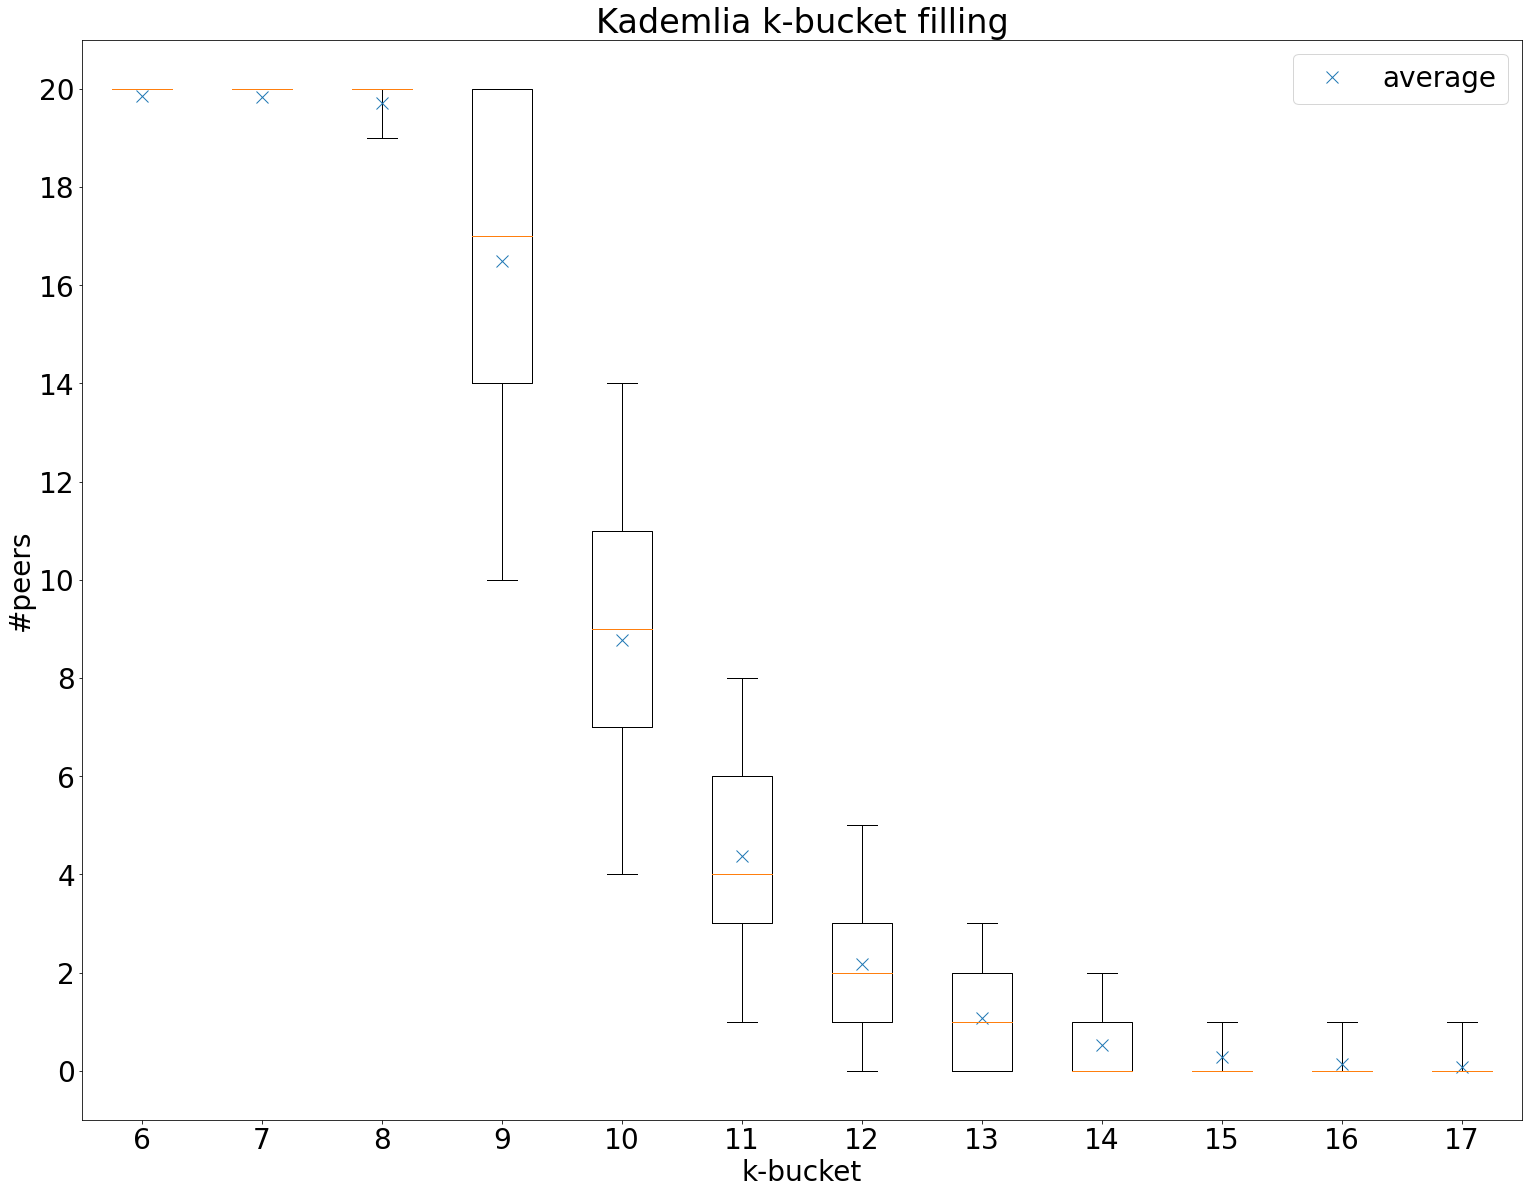

In [97]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))

plt.plot(range(6,18), avg_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')

plt.xlabel("k-bucket")
plt.ylabel("#peers")
plt.grid(False)

plt.title("Kademlia k-bucket filling")
plt.legend()

plt.savefig("plots/kbucket-filling-distribution-all.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

## Alive peers only

In [37]:
avg_alive_in_bucket = np.average(routing_table_distribution_in_kbuckets_alive_data, axis=1)

In [164]:
# average number of peers in the 13th bucket
np.average(routing_table_distribution_in_kbuckets_alive_data[13], axis=0)

0.9076719330855019

In [146]:
# average number of peers in the 9th bucket
np.average(routing_table_distribution_in_kbuckets_alive_data[9], axis=0)

14.165343866171003

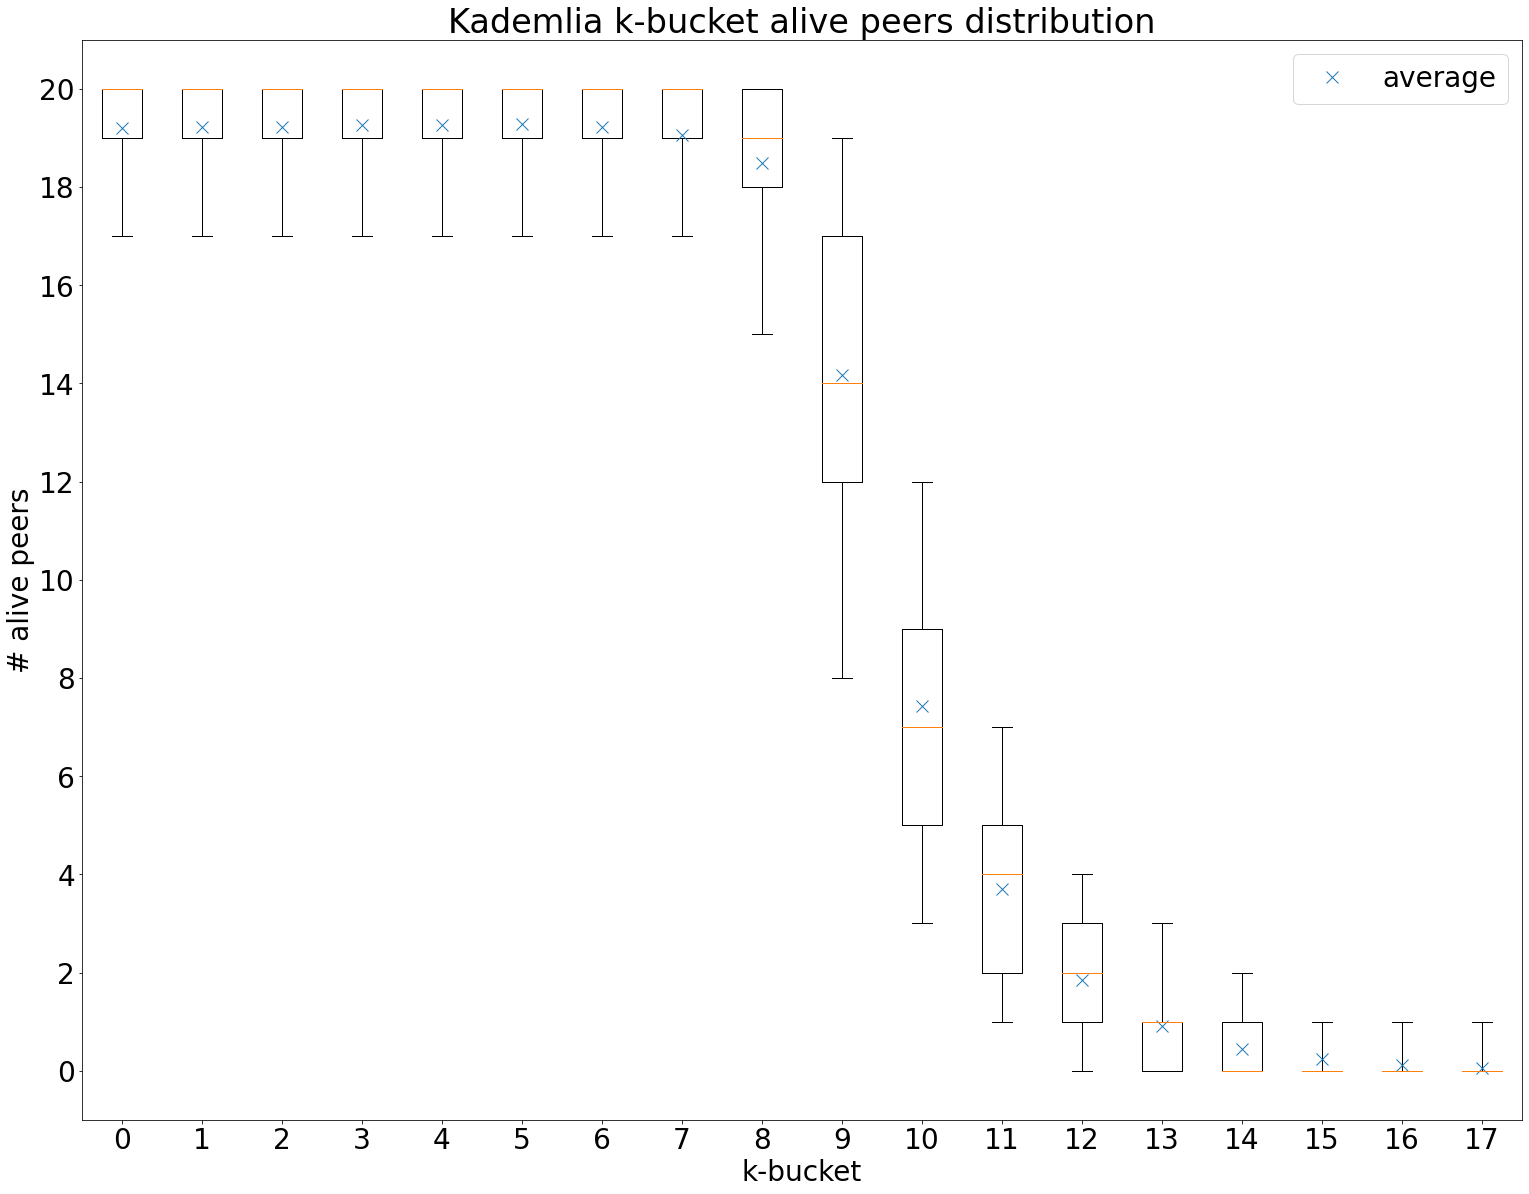

In [142]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_alive_data[:18], positions=range(18),\
                showfliers=False, whis=(5, 95))

plt.plot(range(18), avg_alive_in_bucket[:18], marker='x', markersize=12, ls='', label='average')

plt.xlabel("k-bucket")
plt.ylabel("# alive peers")
plt.grid(False)

plt.title("Kademlia k-bucket alive peers distribution")
plt.legend()

plt.savefig("plots/kbucket-filling-distribution-reachable.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [161]:
theoretical_candidates_per_bucket = [avg_peers_per_crawl * 2**(-(1+i)) for i in range(30)]
all_theoretical_candidates_per_bucket = [total_avg_peers_per_crawl * 2**(-(1+i)) for i in range(30)]

In [165]:
# theoretical number of candidates for the 13th bucket
theoretical_candidates_per_bucket[13]

0.9381975446428571

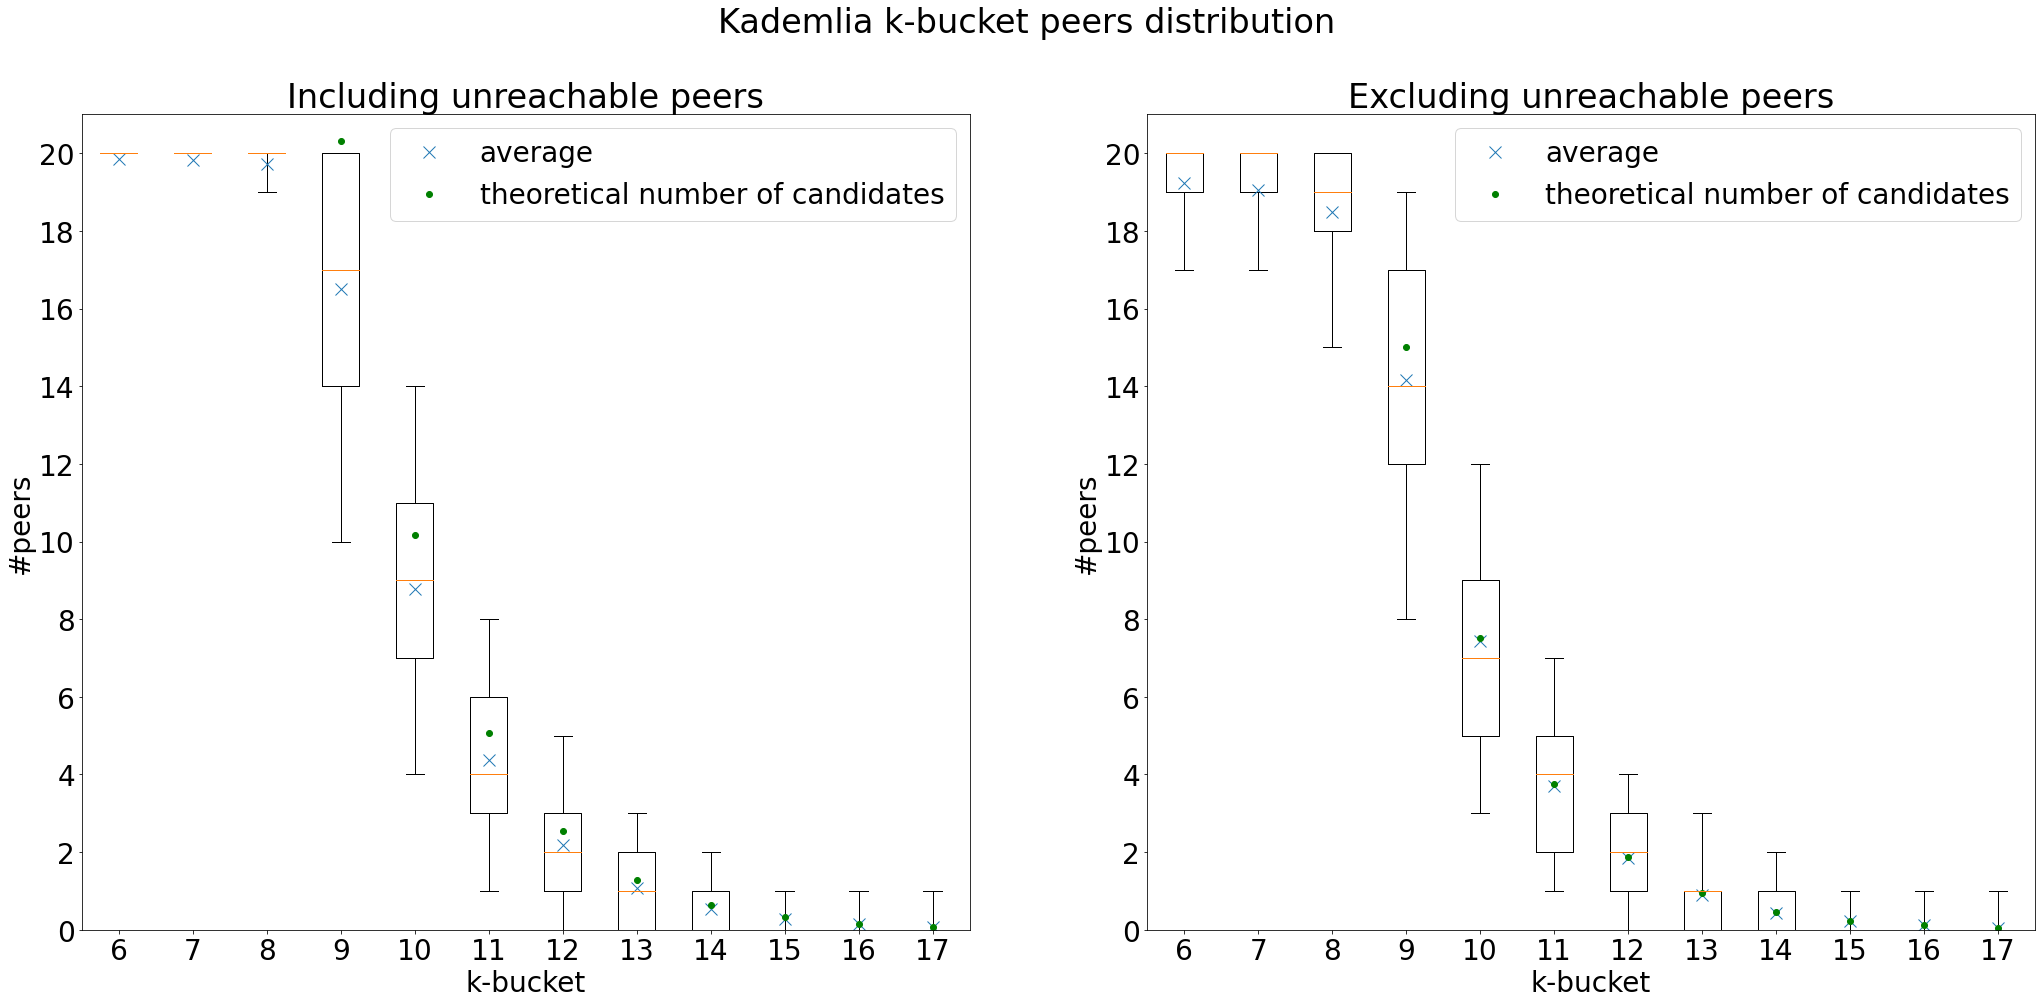

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35,15), facecolor='white', edgecolor ='black')

fig.suptitle('Kademlia k-bucket peers distribution')

ax1.boxplot(routing_table_distribution_in_kbuckets_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))
ax1.plot(range(6,18), avg_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')
ax1.plot(range(6,18), all_theoretical_candidates_per_bucket[6:18], marker='.', markersize=12, ls='', \
         label='theoretical number of candidates', color='green')

ax2.boxplot(routing_table_distribution_in_kbuckets_alive_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))
ax2.plot(range(6,18), avg_alive_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')
ax2.plot(range(6,18), theoretical_candidates_per_bucket[6:18], marker='.', markersize=12, ls='', \
         label='theoretical number of candidates', color='green')


ax1.set_title("Including unreachable peers")
ax1.set_xlabel("k-bucket")
ax1.set_ylabel("#peers")
ax1.set_ylim([0,21])
ax1.set_yticks(range(0, 21, 2))
ax1.legend()

ax2.set_title("Excluding unreachable peers")
ax2.set_xlabel("k-bucket")
ax2.set_ylabel("#peers")
ax2.set_ylim([0,21])
ax2.set_yticks(range(0, 21, 2))
ax2.legend()

plt.savefig("plots/kbucket-filling-distribution.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## Unreachable peers

In [99]:
# computes average and ratio of data gathered from each individual crawl
offline_peers_avg = [avg_in_bucket[i] - avg_alive_in_bucket[i] for i in range(len(avg_in_bucket))]
offline_peers_ratio = [(avg_in_bucket[i] - avg_alive_in_bucket[i])/avg_in_bucket[i] if avg_in_bucket[i] != 0 else 0 for i in range(len(avg_in_bucket))]
online_peers_ratio = [(avg_alive_in_bucket[i])/avg_in_bucket[i] if avg_in_bucket[i] != 0 else 0 for i in range(len(avg_in_bucket))]

In [117]:
# unreachable peer ratio in bucket 0
offline_peers_ratio[0]

0.037752553971526735

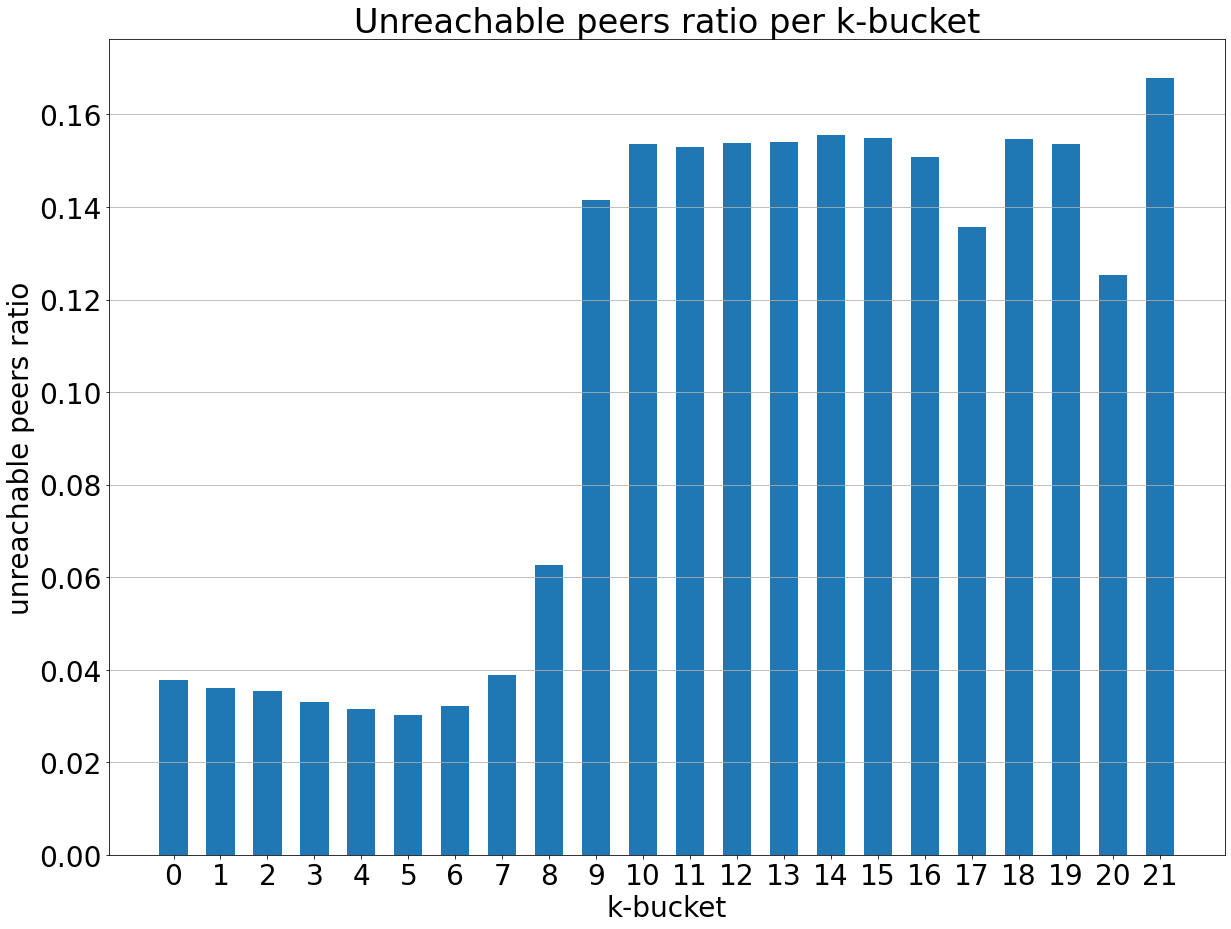

In [144]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.bar([x for x in range(22)], offline_peers_ratio[:22], width=0.6, label='missing peers per bucket')

plt.xlabel("k-bucket")
plt.ylabel("unreachable peers ratio")
plt.title("Unreachable peers ratio per k-bucket")
plt.xticks(range(22))

plt.savefig('plots/unreachable-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')


plt.show()

## Number of peers in the routing table among the 20 closest

In [40]:
closest20_average = []
for data in closest20_cdf_data:
    closest20_average += data

In [41]:
closest20_pdf = [closest20_average.count(x)/len(closest20_average) for x in range(21)]
closest20_cdf = [sum(closest20_pdf[:i+1]) for i in range(len(closest20_pdf))]

In [114]:
# various values of pdf and cdf
print("PDF20:", closest20_pdf[-1])
print("CDF-18-20:", 1-(closest20_pdf[-3]+closest20_pdf[-2]+closest20_pdf[-1]))
print("CDF-17-20:", 1-(closest20_pdf[-4]+closest20_pdf[-3]+closest20_pdf[-2]+closest20_pdf[-1]))
print("CDF17:", closest20_cdf[17])
print("CDF5:", closest20_cdf[5])
print("CDF4:", closest20_cdf[4])
print("CDF2:", closest20_cdf[2])
print("CDF1:", closest20_cdf[1])
print("CDF0:", closest20_cdf[0])

PDF20: 0.6109038104089219
CDF-18-20: 0.04791821561338283
CDF-17-20: 0.02151022304832706
CDF17: 0.0479182156133829
CDF5: 0.0011315055762081785
CDF4: 0.0010223048327137546
CDF2: 0.0008062267657992565
CDF1: 0.0007063197026022305
CDF0: 0.0006319702602230483


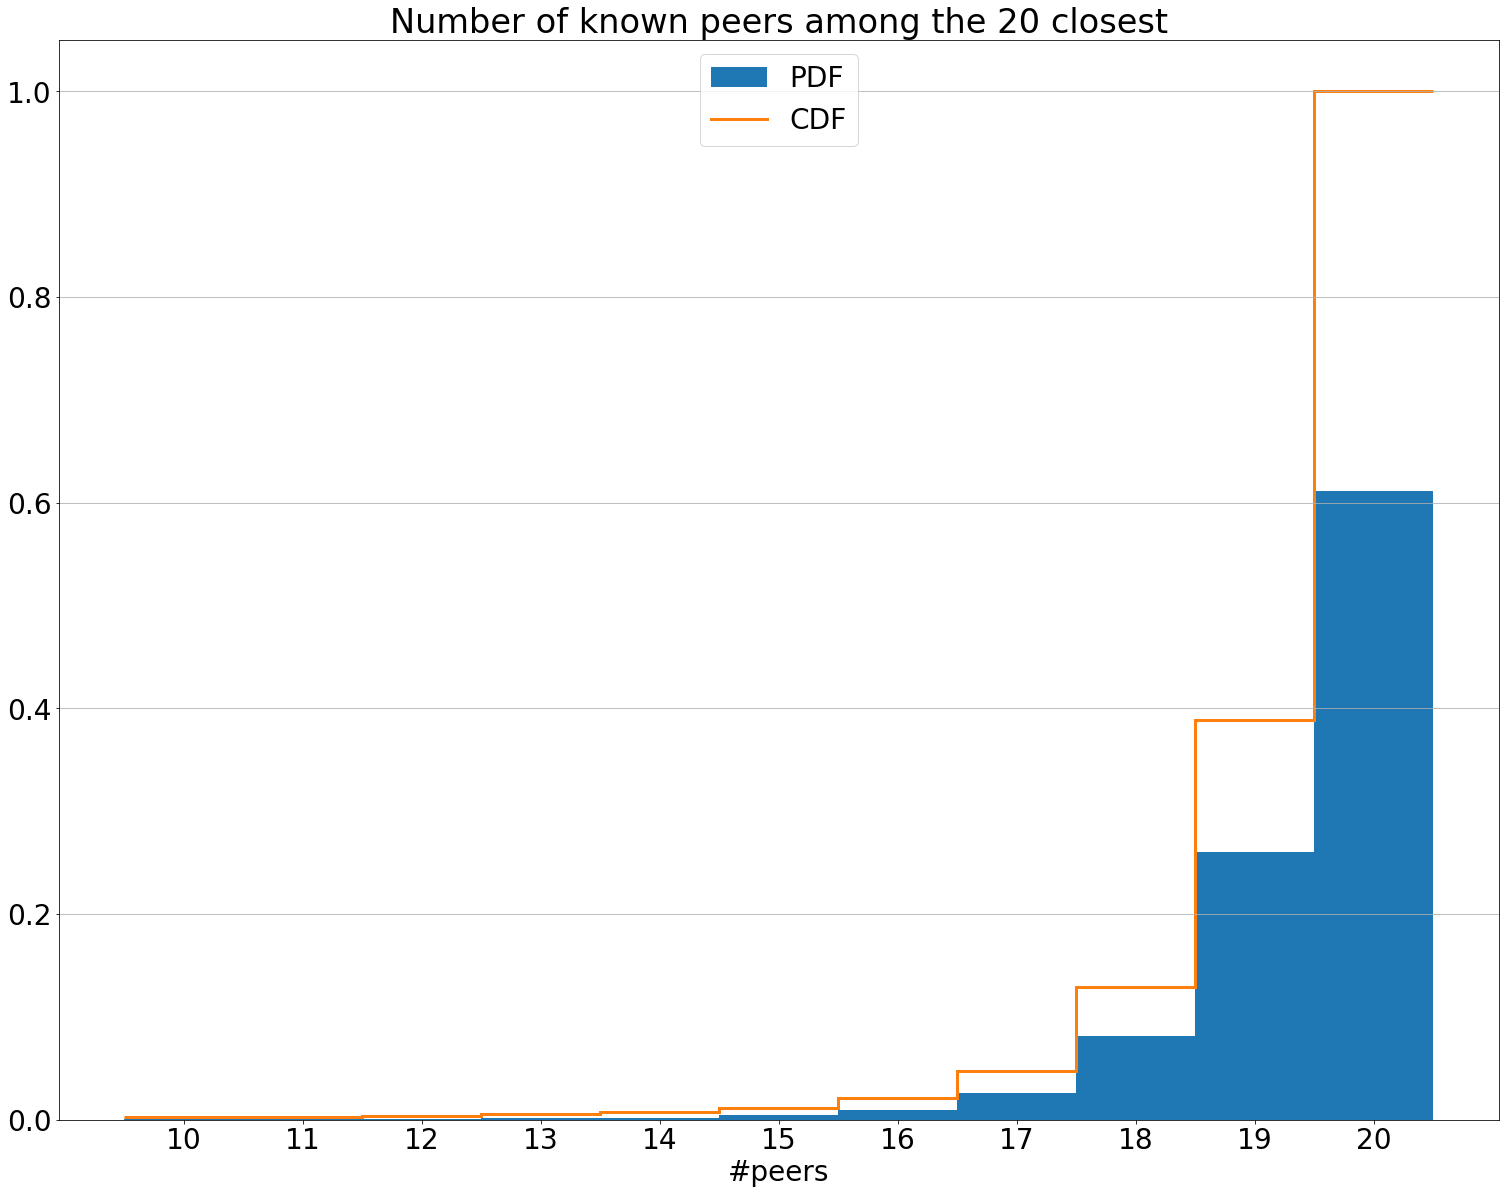

In [102]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

ax.stairs(values=closest20_pdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='PDF', fill=True)
ax.stairs(values=closest20_cdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='CDF', linewidth=3, baseline=None)

plt.grid(axis='y')
plt.xlabel("#peers")
plt.xticks(range(10, 21))
plt.legend(loc='upper center')
plt.title("Number of known peers among the 20 closest")
plt.savefig('plots/known-peers-among-20-closest.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

# Missing peers per bucket

In [43]:
missing_peers_per_bucket_avg = np.average(missing_peers_per_bucket_data, axis=0)
missing_peers_per_non_full_bucket_avg = np.average(missing_peers_per_non_full_bucket_data, axis=0)

In [44]:
avg_bucket_0_8 = np.average(avg_in_bucket[:9], axis=0)
avg_missing_bucket_0_8 = np.average(missing_peers_per_bucket_avg[:9], axis=0)
avg_non_full_bucket_0_8 = np.average(missing_peers_per_non_full_bucket_avg[:9], axis=0)

In [45]:
# average values for bucket 0-8
print(avg_bucket_0_8)
print(avg_missing_bucket_0_8)
print(avg_non_full_bucket_0_8)

19.879127168525404
0.11938503677718135
6.819532525013738


In [46]:
# for bucket 0-8
full_buckets_ratio = 0
for line in routing_table_distribution_in_kbuckets_data[:9]:
    count = 0
    for e in line:
        if e == 20:
            count += 1
    full_buckets_ratio += count/len(line)/9

In [47]:
print(full_buckets_ratio)

0.9806074452705493


In [48]:
# average computations for bucket 9-14
avg_missing_9_14 = np.average(missing_peers_per_bucket_avg[9:15], axis=0)

In [49]:
print(avg_missing_9_14)

0.5304824252247256


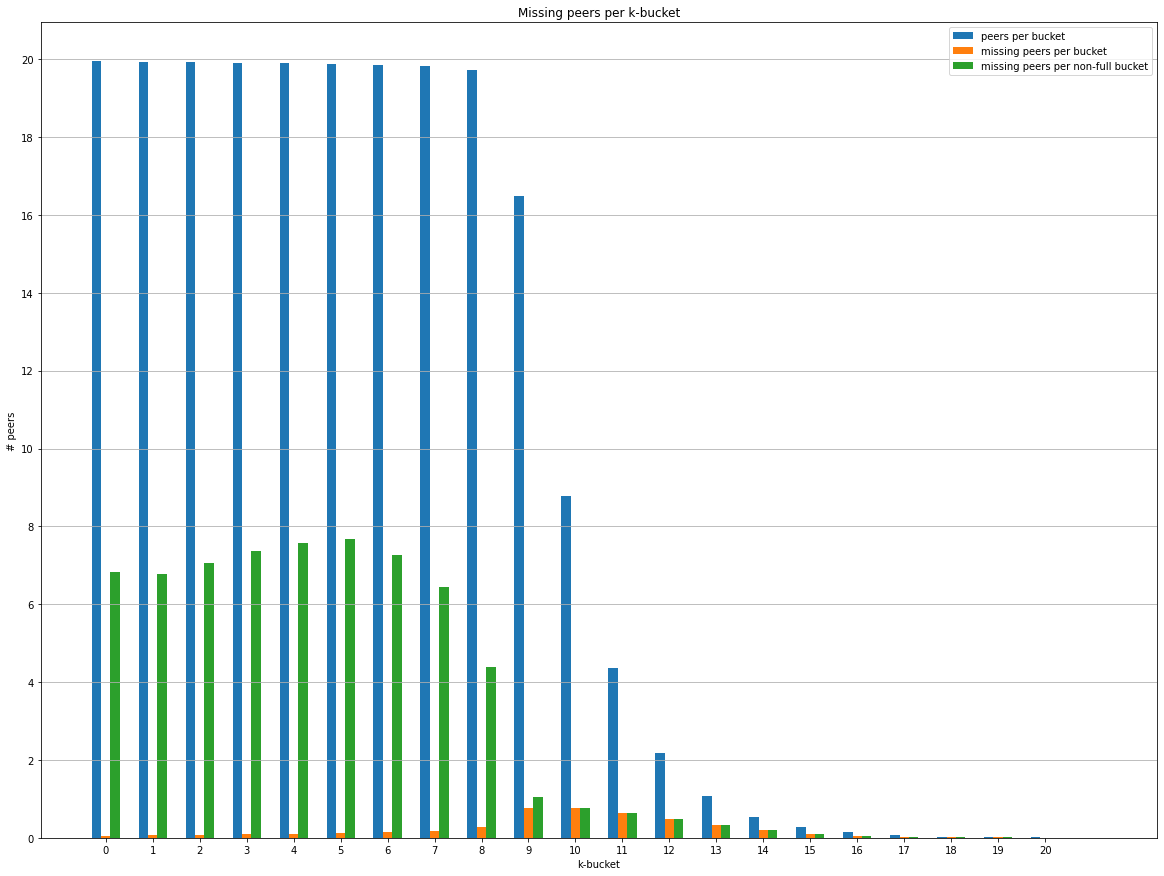

In [50]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.yticks(range(0, 22, 2))
plt.xticks(range(0, 21))

plt.grid(axis='y')
plt.bar([x - 0.2 for x in range(22)], avg_in_bucket[:22], width=0.2, label='peers per bucket')
plt.bar([x for x in range(22)], missing_peers_per_bucket_avg[:22], width=0.2, label='missing peers per bucket')
plt.bar([x + 0.2 for x in range(22)], missing_peers_per_non_full_bucket_avg[:22], width=0.2, label='missing peers per non-full bucket')

#plt.bar(range(22), missing_peers_per_non_full_bucket[:22], width=0.25)

#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Missing peers per k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("# peers")
plt.legend()

plt.savefig('plots/missing-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## Ratio of missing peers per bucket

In [51]:
missing_peers_per_bucket_ratio = [missing_peers_per_bucket_avg[i]/avg_in_bucket[i] for i in range(23)]

In [52]:
for i in range (9, 23):
    print("Bucket "+str(i)+": "+str(int(avg_in_bucket[i]*avg_peers_per_crawl*crawl_count)))

Bucket 9: 7101350
Bucket 10: 3780181
Bucket 11: 1879221
Bucket 12: 935414
Bucket 13: 461777
Bucket 14: 226914
Bucket 15: 119824
Bucket 16: 58876
Bucket 17: 28826
Bucket 18: 14234
Bucket 19: 6792
Bucket 20: 3963
Bucket 21: 1995
Bucket 22: 541


In [53]:
samples_per_buckets = [int(avg_in_bucket[i]*avg_peers_per_crawl*crawl_count) for i in range(25)]

In [115]:
ratio_buckets_9_14 = missing_peers_per_bucket_ratio[9:15]
avg_ratio_buckets_9_14 = sum(ratio_buckets_9_14)/len(ratio_buckets_9_14)

In [116]:
avg_ratio_buckets_9_14

0.19764721700585716

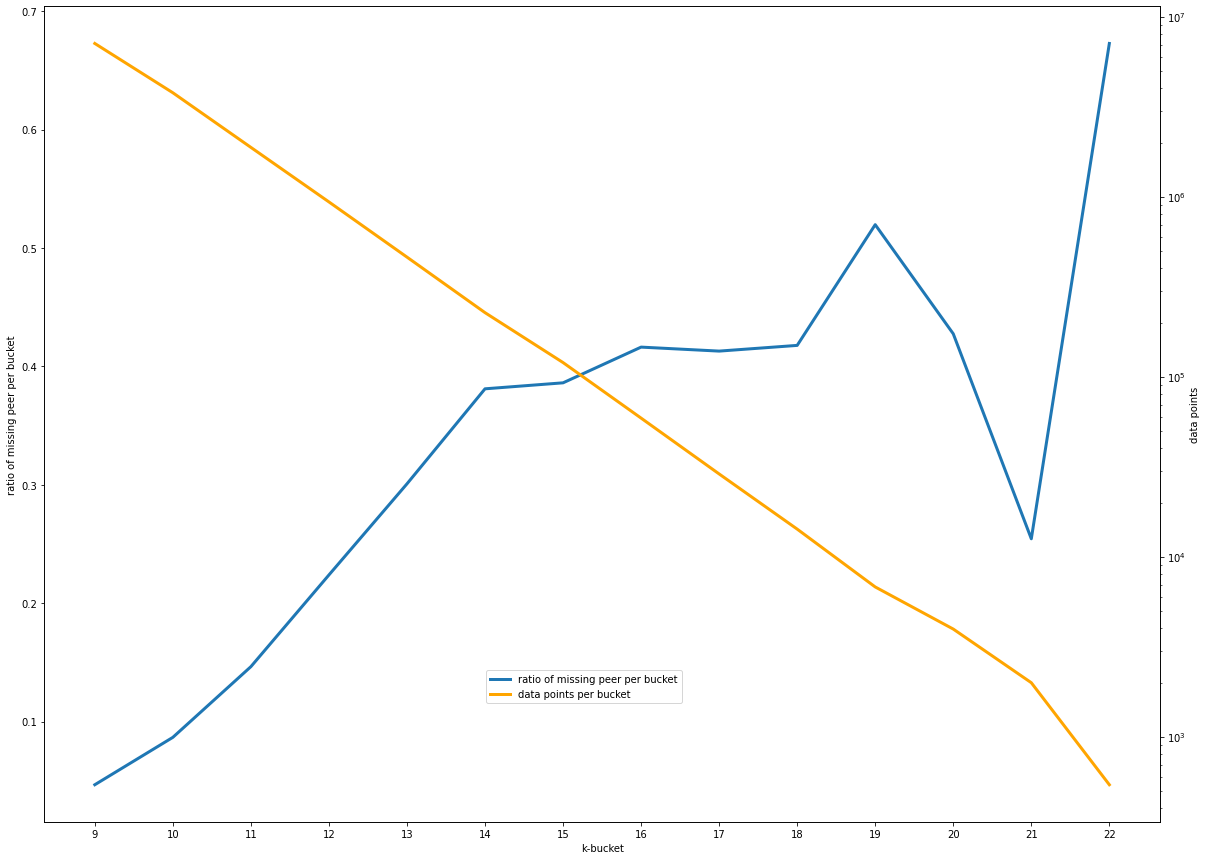

In [54]:
fig, ax1 = plt.subplots(figsize=(20,15), facecolor='white') 
      
plt.xticks(range(9,23))
ax1.set_xlabel('k-bucket')
ax1.set_ylabel('ratio of missing peer per bucket')
plot_1 = ax1.plot(range(9,23), missing_peers_per_bucket_ratio[9:23], label='ratio of missing peer per bucket', linewidth=3)
ax1.tick_params(axis ='y')

# Adding Twin Axes

ax2 = ax1.twinx()
  
ax2.set_ylabel('data points')
ax2.set_yscale('log')
#plot_2 = ax2.plot(range(9,23), avg_in_bucket[9:23], label='average #peers per bucket', color='orange', linewidth=3)
plot_2 = ax2.plot(range(9,23), samples_per_buckets[9:23], label='data points per bucket', color='orange', linewidth=3)
ax2.tick_params(axis ='y')

fig.legend(loc='center',bbox_to_anchor=(0.5, 0.25))

plt.savefig('plots/missing-peers-ratio.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## 20 Closest peers distribution in the k-buckets

In [55]:
closest_peers_avg = []
for line in closest_peers_data:
    closest_peers_avg.append(sum(line)/len(line))

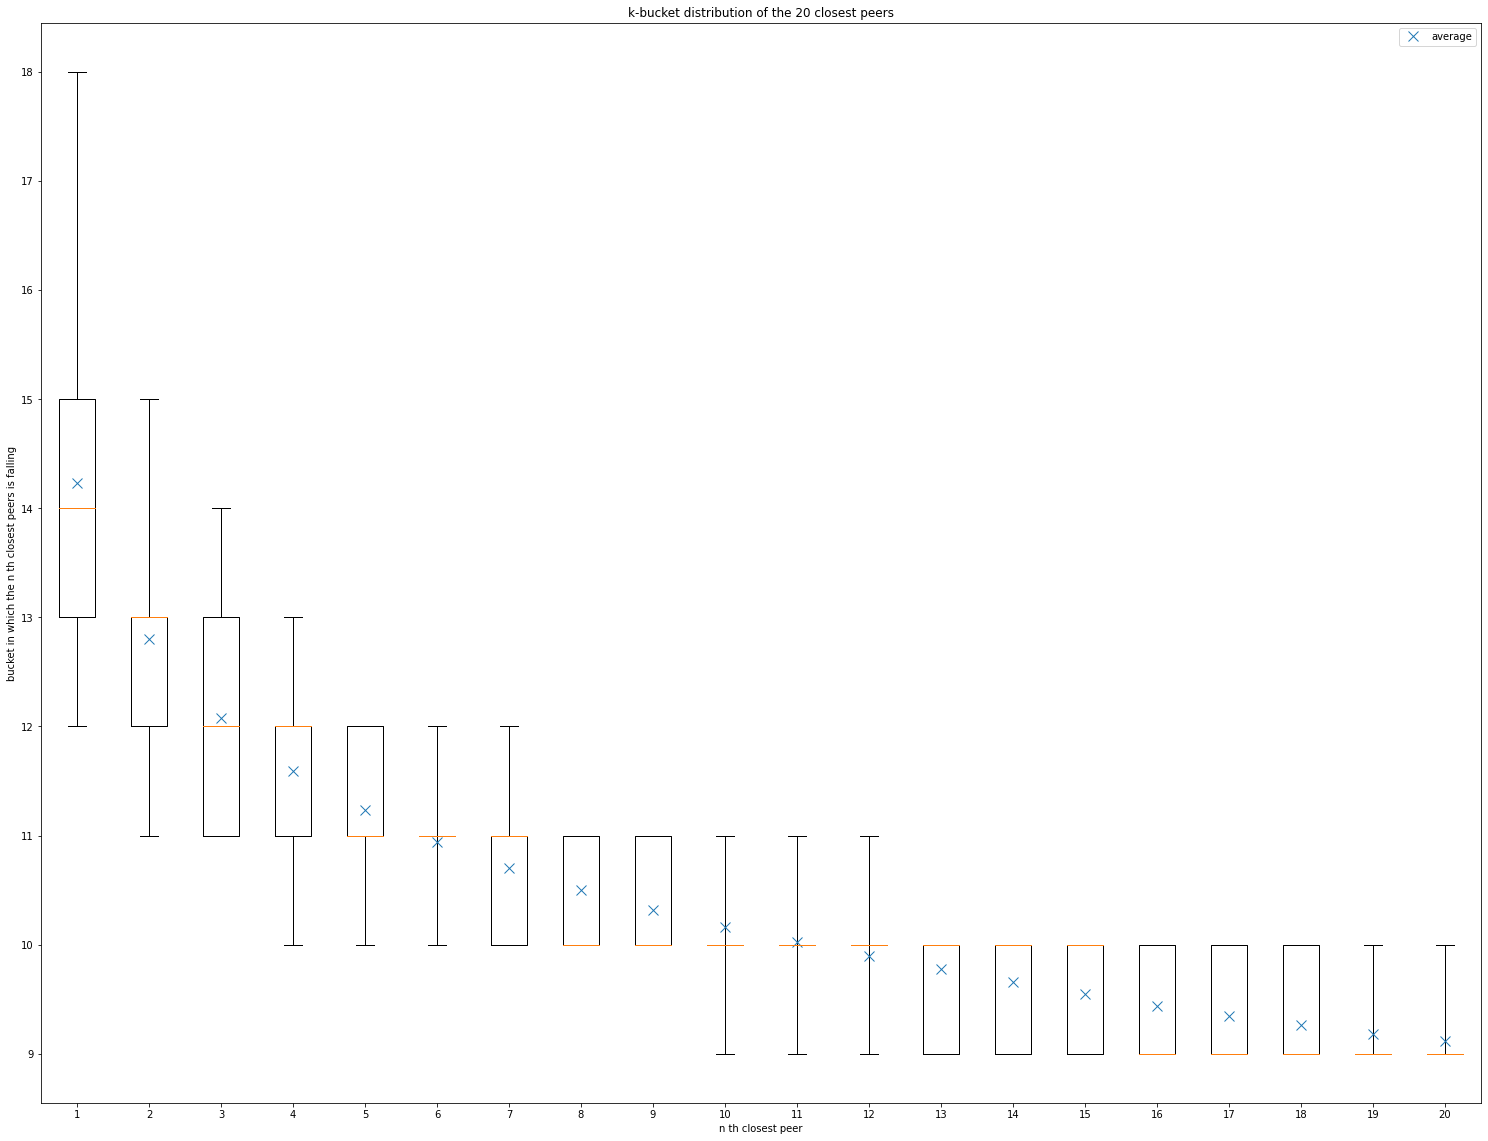

In [56]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

plt.yticks(range(5, 31, 1))

plt.grid(False)
plt.xlabel("n th closest peer")
plt.ylabel("bucket in which the n th closest peers is falling")

#plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(closest_peers_data, whis=(5, 95), showfliers=False)
ax.plot(range(1,21),closest_peers_avg, marker='x', markersize=10, ls='', label='average')

plt.legend()
plt.title("k-bucket distribution of the 20 closest peers")
 
plt.savefig('plots/kbucket-distribution-20-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

## 10 k-bucket distribution of the 10 cloest peers

In [57]:
xClosest = []
for i in range(len(closest_peers_data)):
    total=sum([closest_peers_data[i].count(b) for b in range(9,24)])
    xClosest.append([closest_peers_data[i].count(b)/total for b in range(9,24)])

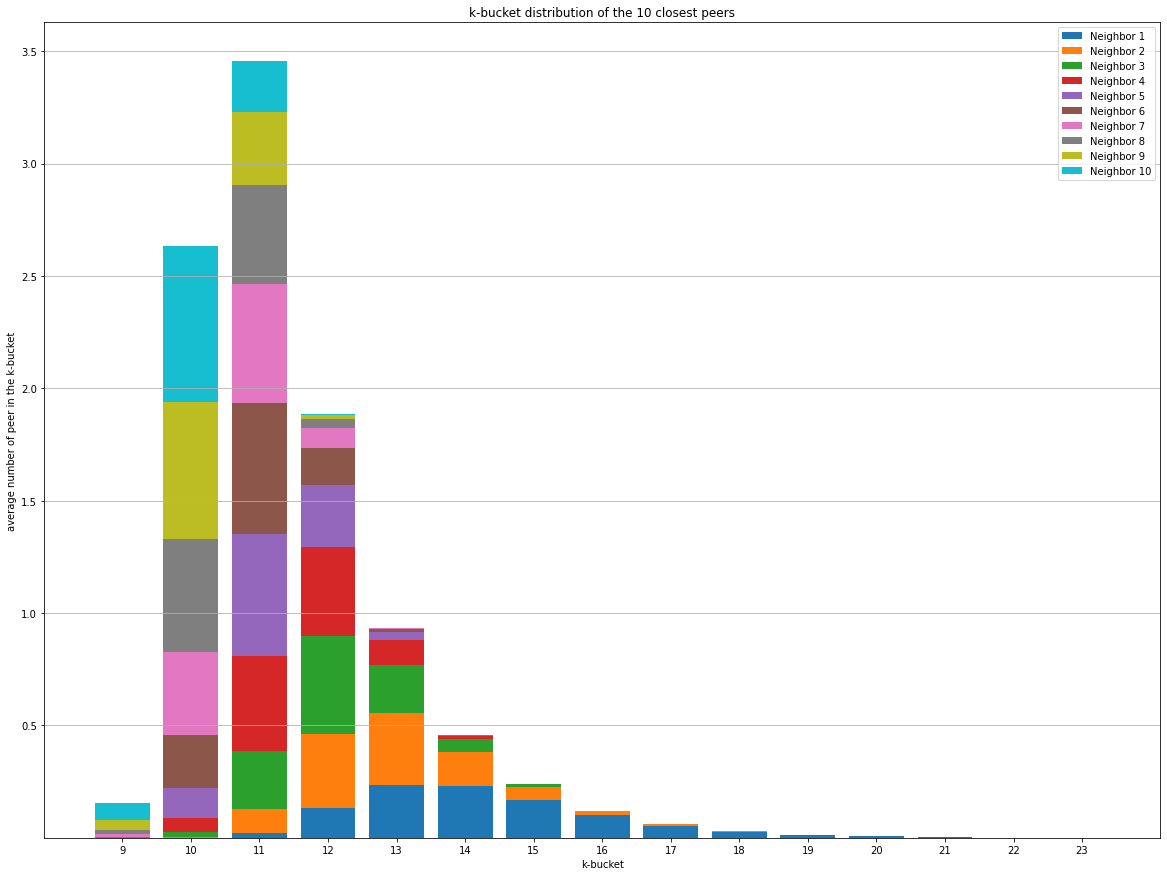

In [58]:
fig, ax = plt.subplots(figsize=(20,15), facecolor='white')

plt.xticks(range(9, 24, 1))

cumsum=[0 for _ in range(9,24)]

for i in range(10):
    label="Neighbor "+str(i+1)
    ax.bar(range(9,24), xClosest[i], bottom=cumsum, label=label)        
    cumsum = [cumsum[j]+xClosest[i][j] for j in range(len(cumsum))]
    
ax.legend()
plt.grid(axis='y')

plt.title("k-bucket distribution of the 10 closest peers")
plt.xlabel("k-bucket")
plt.ylabel("average number of peer in the k-bucket")
plt.savefig('plots/distribution-10-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()